In [1]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/capstone

/content/drive/My Drive/capstone


In [3]:
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144798 sha256=cc5d332e2fb83a73a8a965ce1fe8ae4ba86d94b3b2cec0aaa199ebfb4ed54ee3
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [46]:
import model as m

import argparse
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
import torchtext.data as data
import random
import matplotlib.pyplot as plt
from tqdm import notebook
from sklearn.model_selection import KFold

### train function

In [5]:
def train(config, train_iter, model, criterion, optimizer, epoch, dic, save_path, prob=0):
    global iteration, n_total, train_loss, n_bad_loss
    global init, best_val_loss, stop

    print("=> EPOCH {}".format(epoch))
    train_iter.init_epoch()
    for i, batch in notebook.tqdm(enumerate(train_iter), total=len(train_iter)):
        # TODO 
        # add noise to batch
        g = batch.grapheme
        # if random.random() > prob:
         #   g = grapheme_add_noise(0.1, g, dic)
        
        
        iteration += 1
        model.train()
        output, _, __ = model(g, batch.phoneme[:-1].detach())
        target = batch.phoneme[1:]
        # print(output.size())
        loss = criterion(output.view(output.size(0) * output.size(1), -1),
                         target.view(target.size(0) * target.size(1)))
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip, 'inf')
        optimizer.step()
        
        n_total += batch.batch_size
        train_loss += loss.data * batch.batch_size
        
        # print("   % Time: {:5.0f} | Iteration: {:5} | Batch: {:4}/{}"
        #           " | Train loss: {:.4f}"
        #           .format(time.time()-init, iteration, train_iter.iterations,
        #                   len(train_iter), train_loss))
        
        if iteration % config.log_every == 0:
            train_loss /= n_total
            val_loss = validate(val_iter, model, criterion)
            print("   % Time: {:5.0f} | Iteration: {:5} | Batch: {:4}/{}"
                  " | Train loss: {:.4f} | Val loss: {:.4f}"
                  .format(time.time()-init, iteration, train_iter.iterations,
                          len(train_iter), train_loss, val_loss))
            
            # test for val_loss improvement
            n_total = train_loss = 0
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                torch.save(model.state_dict(), save_path)
            else:
                n_bad_loss += 1
            if n_bad_loss == config.n_bad_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                m.adjust_learning_rate(optimizer, config.lr_decay)
                new_lr = optimizer.param_groups[0]['lr']
                print("=> Adjust learning rate to: {}".format(new_lr))
                if new_lr < config.lr_min:
                    stop = True
                    break

### Validation Function

In [6]:
def validate(val_iter, model, criterion):
    model.eval()
    val_loss = 0
    val_iter.init_epoch()
    for batch in val_iter:
        output, _, __ = model(batch.grapheme, batch.phoneme[:-1])
        target = batch.phoneme[1:]
        loss = criterion(output.squeeze(1), target.squeeze(1))
        val_loss += loss.data * batch.batch_size
    
    return val_loss / len(val_iter.dataset)

### Test Function

In [7]:
def test(test_iter, model, g_dic, p_dic, print_error=False):
    model.eval()
    test_iter.init_epoch()
    test_per = 0
    wrong = []
    with torch.no_grad():
        for batch in test_iter:
            output = model(batch.grapheme).data.tolist()
            target = batch.phoneme[1:].squeeze(1).data.tolist()
            # calculate per, wer here
            try:
                per = m.phoneme_error_rate(output[:output.index(3) + 1], target)
            except ValueError:
                per = m.phoneme_error_rate(output, target) 

            if per > 0:
                
                tmp = list([g_dic[g] for g in batch.grapheme])
                tmp.reverse()
                wrong.append(tmp)

                if print_error:        
                    print("Grapheme: {}\nTarget: {}\nPrediction: {}\n".format(
                      ''.join(tmp),
                      ' '.join([p_dic[p] for p in target]),
                      ' '.join([p_dic[p] for p in output])))

            test_per += per  # batch_size = 1
        
        test_per = test_per / len(test_iter.dataset) * 100
        print("Phoneme error rate (PER): {:.2f}\n"
              .format(test_per))
    
    return test_per, wrong

In [8]:
def print_result(model, lines, grapheme, g_dic, p_dic):
    g = grapheme[:-3]
    for line in lines:
        if line.strip().split()[0] == g:
            target = line.strip().split()[1:]

    input = [2]
    for letter in g:
        input.insert(1, g_dic.index(letter))
    input = torch.unsqueeze(torch.LongTensor(input).to("cuda"), 1)
    
    with torch.no_grad():

        output = model(input).data.tolist()

     
    print("Grapheme: {}\nTarget: {}\nPrediction: {}\n".format(
            g, ' '.join(target), ' '.join([p_dic[p] for p in output[:-1]]) ) )

## Set parameter

In [9]:
parser = {
    'num_row': -1, # modify num_row to -1 if you want to input all data points
    'epochs': 15,
    'batch_size': 128,
    'max_len': 20,  # max length of grapheme/phoneme sequences
    'beam_size': 5,  # size of beam for beam-search
    'd_embed': 30,  # embedding dimension
    'd_hidden': 64,  # hidden dimension
    'attention': True,  # use attention or not
    'log_every': 100,  # number of iterations to log and validate training
    'lr': 0.007,  # initial learning rate
    'lr_decay': 0.5,  # decay lr when not observing improvement in val_loss
    'lr_min': 3e-4,  # stop when lr is too low
    'n_bad_loss': 3,  # number of bad val_loss before decaying
    'clip': 2.3,  # clip gradient, to avoid exploding gradient
    'cuda': True,  # using gpu or not
    'seed': 1234,  # initial seed
}
args = argparse.Namespace(**parser)

In [10]:
args.cuda = args.cuda and torch.cuda.is_available()

# if not os.path.isdir(args.intermediate_path):
#     os.makedirs(args.intermediate_path)
# if not os.path.isdir(args.data_path):
#     os.makedirs(args.data_path)
#     URL = "https://github.com/cmusphinx/cmudict/archive/master.zip"
#     !wget $URL -O ./data/cmudict.zip
#     !unzip ./data/cmudict.zip -d ./data/
#     !mv ./data/cmudict-master $args.data_path

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

## split the data and build dataloader

In [11]:
import pandas as pd
import pickle
from sklearn import model_selection

In [12]:
df = pd.read_csv("filtered_no_stress_freq.csv", index_col=0)

In [13]:
df.head()

,word,frequency
0,'bout B AW T\n,1
1,'em AH M\n,41
2,'round R AW N D\n,5
3,'tis T IH Z\n,2
4,a AH\n,23195


In [51]:
kf = KFold(n_splits=10)

In [52]:
new_df = df.sample(frac=1, random_state=777)
kf.get_n_splits(new_df)

10

In [55]:
new_df.head()

,word,frequency
11153,fame F EY M\n,18
8225,derived D ER AY V D\n,39
21291,orthodontist AO R TH AH D AA N T AH S T\n,9
14817,humanities HH Y UW M AE N IH T IY Z\n,2
26477,sausage S AO S AH JH\n,1


In [63]:
# please rerun this line if you need to retrain the model!!!
cv_generator = kf.split(new_df)

In [64]:
for train_index, test_index in cv_generator:
    train_set, val_set = model_selection.train_test_split(new_df.iloc[train_index,], test_size=0.2222, random_state=args.seed)
    test_set = new_df.iloc[test_index,]



(30612, 2)
(3402, 2)
[3402 3403 3404 3405 3406]
[0 1 2 3 4]
                                               word  frequency
29494  substantiates S AH B S T AE N CH IY EY T S\n          1
31008                     toppings T AA P IH NG Z\n          1
4110        burgomaster's B ER G AH M AE S T ER Z\n          1
2818                                bend B EH N D\n         24
29478     subsidiaries S AH B S IH D IY EH R IY Z\n          2
(30612, 2)
(3402, 2)
[0 1 2 3 4]
[3402 3403 3404 3405 3406]
                                            word  frequency
11153                              fame F EY M\n         18
8225                       derived D ER AY V D\n         39
21291  orthodontist AO R TH AH D AA N T AH S T\n          9
14817      humanities HH Y UW M AE N IH T IY Z\n          2
26477                     sausage S AO S AH JH\n          1
(30612, 2)
(3402, 2)
[0 1 2 3 4]
[6804 6805 6806 6807 6808]
                                            word  frequency
11153                 

In [ ]:
train_set, test_set = model_selection.train_test_split(df, test_size=0.3, random_state=args.seed)

In [ ]:
val_set, test_set = model_selection.train_test_split(test_set, test_size=0.333, random_state=args.seed)

In [ ]:
train_set.shape, val_set.shape, test_set.shape

((23809, 2), (6806, 2), (3399, 2))

In [ ]:
weight = np.clip(train_set["frequency"].tolist(), 0, 1000)

In [ ]:
np.random.seed(args.seed)
train_lines = np.random.choice(train_set["word"].tolist(), size=100000, p=(np.array(weight) / sum(weight)) )

In [ ]:
val_lines = val_set["word"].tolist()
test_lines = test_set["word"].tolist()

In [ ]:
train_iter, val_iter, test_iter, g_field, p_field = m.prepare_data(train_lines, val_lines, test_lines, args)
dic = g_field.vocab.itos

# Train the model

In [ ]:
#set up configuration
config = args
config.g_size = len(g_field.vocab)
config.p_size = len(p_field.vocab)
config.d_hidden = 64
save_path = "model_para/best_model_" + str(config.d_hidden) + ".pt"
    
model = m.G2P(config)
criterion = nn.NLLLoss()
if config.cuda:
    model.cuda()
    criterion.cuda()
optimizer = optim.Adam(model.parameters(), lr=config.lr)  # use Adagrad
    
# training
iteration = n_total = train_loss = n_bad_loss = 0
stop = False
best_val_loss = 10
init = time.time()

# If you want to change epoch, uncomment the following line
# config.epochs = 10

for epoch in range(1, config.epochs+1):
    train(config, train_iter, model, criterion, optimizer, epoch, dic, save_path)
    if stop:
        break

=> EPOCH 1


   % Time:    29 | Iteration:   100 | Batch:  100/782 | Train loss: 1.3456 | Val loss: 2.6551
   % Time:    57 | Iteration:   200 | Batch:  200/782 | Train loss: 0.6078 | Val loss: 1.2035
   % Time:    85 | Iteration:   300 | Batch:  300/782 | Train loss: 0.2375 | Val loss: 0.8229
   % Time:   114 | Iteration:   400 | Batch:  400/782 | Train loss: 0.1462 | Val loss: 0.6921
   % Time:   142 | Iteration:   500 | Batch:  500/782 | Train loss: 0.1122 | Val loss: 0.6706
   % Time:   170 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0920 | Val loss: 0.6149
   % Time:   198 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0846 | Val loss: 0.5711

=> EPOCH 2


   % Time:   226 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0711 | Val loss: 0.5630
   % Time:   254 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0588 | Val loss: 0.5677
   % Time:   282 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0582 | Val loss: 0.5388
   % Time:   311 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0570 | Val loss: 0.5512
   % Time:   339 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0528 | Val loss: 0.5282
   % Time:   367 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0541 | Val loss: 0.5337
   % Time:   396 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0522 | Val loss: 0.5452
=> Adjust learning rate to: 0.0035
   % Time:   424 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0440 | Val loss: 0.4859

=> EPOCH 3


   % Time:   453 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0356 | Val loss: 0.4828
   % Time:   482 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0315 | Val loss: 0.4938
   % Time:   511 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0294 | Val loss: 0.4828
=> Adjust learning rate to: 0.00175
   % Time:   540 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0287 | Val loss: 0.4578
   % Time:   568 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0251 | Val loss: 0.4486
   % Time:   596 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0259 | Val loss: 0.4596
   % Time:   624 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0250 | Val loss: 0.4556
=> Adjust learning rate to: 0.000875
   % Time:   652 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0244 | Val loss: 0.4484

=> EPOCH 4


   % Time:   681 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0208 | Val loss: 0.4528
   % Time:   709 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0202 | Val loss: 0.4495
=> Adjust learning rate to: 0.0004375
   % Time:   737 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0199 | Val loss: 0.4501
   % Time:   765 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0197 | Val loss: 0.4504
=> Adjust learning rate to: 0.00021875
   % Time:   794 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0195 | Val loss: 0.4534
   % Time:   822 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0200 | Val loss: 0.4511
=> Adjust learning rate to: 0.000109375
   % Time:   851 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0187 | Val loss: 0.4499
   % Time:   879 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0188 | Val loss: 0.4497

=> EPOCH 5


   % Time:   908 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0181 | Val loss: 0.4508
   % Time:   937 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0174 | Val loss: 0.4524
=> Adjust learning rate to: 5.46875e-05
   % Time:   966 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0196 | Val loss: 0.4506
   % Time:   995 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0171 | Val loss: 0.4513
   % Time:  1024 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0187 | Val loss: 0.4516
=> Adjust learning rate to: 2.734375e-05
   % Time:  1053 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0175 | Val loss: 0.4514
   % Time:  1082 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0175 | Val loss: 0.4524
   % Time:  1111 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0175 | Val loss: 0.4521
=> Adjust learning rate to: 1.3671875e-05

=> EPOCH 6


   % Time:  1140 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0182 | Val loss: 0.4518
   % Time:  1168 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0173 | Val loss: 0.4521
   % Time:  1197 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0178 | Val loss: 0.4522
=> Adjust learning rate to: 6.8359375e-06


In [ ]:
test_per, mis_classified = test(test_iter, model, g_dic=g_field.vocab.itos, p_dic=p_field.vocab.itos)

Phoneme error rate (PER): 12.40



In [ ]:
len(mis_classified)

1793

## Load the model

In [ ]:
#show the result
config = args
config.g_size = len(g_field.vocab)
config.p_size = len(p_field.vocab)

config.d_hidden = 64
model0 = m.G2P(config)
model0.to("cuda")
model0.load_state_dict(torch.load("model_para/best_model_64.pt"))

<All keys matched successfully>

In [ ]:
model0

G2P(
  (encoder): Encoder(
    (embedding): Embedding(32, 30)
    (lstm): LSTMCell(30, 64)
  )
  (decoder): Decoder(
    (embedding): Embedding(43, 30)
    (lstm): LSTMCell(30, 64)
    (attn): Attention(
      (linear): Linear(in_features=128, out_features=64, bias=False)
    )
    (linear): Linear(in_features=64, out_features=43, bias=True)
  )
)

In [ ]:
test_per0, mis_classified0 = test(test_iter, model0, g_dic=g_field.vocab.itos, p_dic=p_field.vocab.itos)

Phoneme error rate (PER): 12.41



In [ ]:
#show the result
config = args
config.g_size = len(g_field.vocab)
config.p_size = len(p_field.vocab)

config.d_hidden = 128
model1 = m.G2P(config)
model1.to("cuda")
model1.load_state_dict(torch.load("model_para/best_model_128.pt"))

<All keys matched successfully>

In [ ]:
test_per1, mis_classified1 = test(test_iter, model1, g_dic=g_field.vocab.itos, p_dic=p_field.vocab.itos)

Phoneme error rate (PER): 14.05



In [ ]:
config = args
config.g_size = len(g_field.vocab)
config.p_size = len(p_field.vocab)

config.d_hidden = 256
model2 = m.G2P(config)
model2.to("cuda")
model2.load_state_dict(torch.load("model_para/best_model_256.pt"))

<All keys matched successfully>

In [ ]:
test_per2, mis_classified2 = test(test_iter, model2, g_dic=g_field.vocab.itos, p_dic=p_field.vocab.itos)

Phoneme error rate (PER): 12.35



In [ ]:
config = args
config.g_size = len(g_field.vocab)
config.p_size = len(p_field.vocab)

config.d_hidden = 512
model3 = m.G2P(config)
model3.to("cuda")
model3.load_state_dict(torch.load("model_para/best_model_512.pt"))

<All keys matched successfully>

In [ ]:
test_per3, mis_classified3 = test(test_iter, model3, g_dic=g_field.vocab.itos, p_dic=p_field.vocab.itos)

Phoneme error rate (PER): 8.40



In [ ]:
len(mis_classified3)

1316

In [ ]:
len(set(["".join(a) for a in miss_classified]).union(set(["".join(a) for a in miss_classified3])))

1327

## Comparing result

In [ ]:
lines = df["word"].tolist()

In [ ]:
len(mis_classified0), len(mis_classified1), len(mis_classified2), len(mis_classified3) 

(1793, 2008, 1823, 1316)

In [ ]:
set0 = set(["".join(a) for a in mis_classified0])
set1 = set(["".join(a) for a in mis_classified1])
set2 = set(["".join(a) for a in mis_classified2])
set3 = set(["".join(a) for a in mis_classified3])

In [ ]:
# how many words that has been misclassfied by 64-h model and 128-h model
len(set0.intersection(set1))

1321

In [ ]:
# how many words that has been misclassfied by 128-h model and 256-h model
len(set1.intersection(set2))

1374

In [ ]:
# how many words that has been misclassfied by 256-h model and 512-h model
len(set2.intersection(set3))

1027

In [ ]:
only_mis_by_set1 = set1 - set1.intersection(set2)
len(only_mis_by_set1)

634

In [ ]:
only_mis_by_set2 = set2 - set1.intersection(set2)
len(only_mis_by_set2)

449

In [ ]:
# this is the smaller model
tmp = random.sample(only_mis_by_set1, 20)
for t in tmp:
    print_result(model1, lines, t, g_field.vocab.itos, p_field.vocab.itos)

Grapheme: comprises
Target: K AH M P R AY Z AH Z
Prediction: K AH M P R AY Z IH Z

Grapheme: wintered
Target: W IH N T ER D
Prediction: IH N T ER D

Grapheme: guitars
Target: G IH T AA R Z
Prediction: G Y UW AH T ER Z

Grapheme: morocco
Target: M ER AA K OW
Prediction: B EH R AH K OW

Grapheme: embargo
Target: EH M B AA R G OW
Prediction: M EH M B AA R G OW

Grapheme: refueling
Target: R IY F Y UW AH L IH NG
Prediction: R AH F Y UW L IH NG

Grapheme: list
Target: L IH S T
Prediction: IH S T

Grapheme: rightness
Target: R AY T N AH S
Prediction: AY T N AH S

Grapheme: beebe
Target: B IY B IY
Prediction: B IY B

Grapheme: heave
Target: HH IY V
Prediction: HH EH V

Grapheme: tabulation
Target: T AE B Y AH L EY SH AH N
Prediction: AE B Y AH L EY SH AH N

Grapheme: poles
Target: P OW L Z
Prediction: OW L Z

Grapheme: schone
Target: SH OW N
Prediction: S K OW N

Grapheme: momentary
Target: M OW M AH N T EH R IY
Prediction: M AA M AH N T EH R IY

Grapheme: unknowingly
Target: AH N N OW IH NG 

In [ ]:
# this is the larger model
tmp = random.sample(only_mis_by_set2, 20)
for t in tmp:
    print_result(model2, lines, t, g_field.vocab.itos, p_field.vocab.itos)

Grapheme: overdoing
Target: OW V ER D UW IH NG
Prediction: AH V ER D OW IH NG

Grapheme: orphanage
Target: AO R F AH N AH JH
Prediction: AO R F AE N AH JH

Grapheme: fair
Target: F EH R
Prediction: EH R

Grapheme: experimenters
Target: IH K S P EH R AH M EH N T ER Z
Prediction: IH K S P EH R IH M AH N T ER Z

Grapheme: crew's
Target: K R UW Z
Prediction: R UW Z

Grapheme: capitalize
Target: K AE P AH T AH L AY Z
Prediction: K AE P IH T AH L AY Z

Grapheme: esters
Target: EH S T ER Z
Prediction: S T ER Z

Grapheme: grossly
Target: G R OW S L IY
Prediction: G R AO S L IY

Grapheme: merged
Target: M ER JH D
Prediction: ER JH D

Grapheme: hampers
Target: HH AE M P ER Z
Prediction: AE M P ER Z

Grapheme: adair
Target: AH D EH R
Prediction: EH D ER

Grapheme: rembrandt
Target: R EH M B R AE N T
Prediction: R EH M B R AH N T

Grapheme: fluke
Target: F L UW K
Prediction: L UW K

Grapheme: ducking
Target: D AH K IH NG
Prediction: K AH K IH NG

Grapheme: germ
Target: JH ER M
Prediction: ER M

Gr

In [ ]:
# how many words that has been misclassified by all models
len(set0.intersection(set1).intersection(set2).intersection(set3))

799

In [ ]:
all_misclassified = set0.intersection(set1).intersection(set2).intersection(set3)

In [ ]:
print_result(model1, lines, 'accusation<s>', g_field.vocab.itos, p_field.vocab.itos)

Grapheme: accusation
Target: AE K Y AH Z EY SH AH N
Prediction: AH K Y UW Z EY SH AH N



In [ ]:
print_result(model2, lines, 'accusation<s>', g_field.vocab.itos, p_field.vocab.itos)

Grapheme: accusation
Target: AE K Y AH Z EY SH AH N
Prediction: AH K Y UW Z EY SH AH N



In [ ]:
print_result(model3, lines, 'accusation<s>', g_field.vocab.itos, p_field.vocab.itos)

Grapheme: accusation
Target: AE K Y AH Z EY SH AH N
Prediction: AE K Y AH S EY SH AH N



In [ ]:
# words that has been misclassified by all models
all_misclassified

{'a.m.<s>',
 'aaa<s>',
 'abhorrent<s>',
 'aborigine<s>',
 'abrams<s>',
 'abyss<s>',
 'accusation<s>',
 'accusations<s>',
 'aces<s>',
 'acropolis<s>',
 'actuate<s>',
 'adirondack<s>',
 'advisedly<s>',
 'aficionado<s>',
 'aforethought<s>',
 'africa<s>',
 'agencies<s>',
 'agency<s>',
 'agents<s>',
 'agitators<s>',
 'aisle<s>',
 'alas<s>',
 'alexei<s>',
 'algae<s>',
 'algorithm<s>',
 'alix<s>',
 'all-purpose<s>',
 'allegorical<s>',
 'allure<s>',
 'ambulances<s>',
 'ambushed<s>',
 'amid<s>',
 'amigo<s>',
 'amounted<s>',
 'andrei<s>',
 'angeles<s>',
 'anion<s>',
 'anions<s>',
 'anticipatory<s>',
 'antipodes<s>',
 'antiquated<s>',
 'antoine<s>',
 'aparicio<s>',
 'apotheosis<s>',
 'appellant<s>',
 'appleton<s>',
 'appreciatively<s>',
 'appropriates<s>',
 'aqueous<s>',
 'aquinas<s>',
 'argentina<s>',
 'aristide<s>',
 'arizona<s>',
 'arrogance<s>',
 'artifice<s>',
 'artur<s>',
 'arundel<s>',
 'assay<s>',
 'assisted<s>',
 'auburn<s>',
 'auctioneer<s>',
 'auditing<s>',
 'audition<s>',
 "aujourd'hu

In [ ]:
config = args
config.g_size = len(g_field.vocab)
config.p_size = len(p_field.vocab)

config.d_hidden = 1024
model4 = m.G2P(config)
model4.to("cuda")
model4.load_state_dict(torch.load("model_para/best_model_1024.pth"))

<All keys matched successfully>

In [ ]:
test_per = test(test_iter, model4, criterion)

Phoneme error rate (PER): 18.42



## Ignoring the following block for now

In [ ]:
re = pd.read_excel("Reg_Irregular Words.xlsx")

In [ ]:
regular_list = re.iloc[0:100,]["Regular"].tolist()

In [ ]:
irregular_list = re.iloc[0:100,]["Irregular"].tolist()

In [ ]:
dic = g_field.vocab.itos

In [ ]:
re_predictions = {}
with torch.no_grad():
    for word in regular_list:
        embed = [2]
        for letter in word:
            embed.insert(1, dic.index(letter))
        embed = torch.unsqueeze(torch.LongTensor(embed), 1).to('cuda')
        prediction = model(embed).data.tolist()
        re_predictions[word] = [p_field.vocab.itos[p] for p in prediction]
        

In [ ]:
irre_predictions = {}
with torch.no_grad():
    for word in irregular_list:
        word = word.lower()
        embed = [2]
        for letter in word:
            embed.insert(1, dic.index(letter))
        embed = torch.unsqueeze(torch.LongTensor(embed), 1).to('cuda')
        prediction = model(embed).data.tolist()
        irre_predictions[word] = [p_field.vocab.itos[p] for p in prediction]
        

In [ ]:
lines = df["0"].tolist()

In [ ]:
re_predictions["happen"]

['IY1', 'R', 'P', 'D', '</os>']

In [ ]:
answer_sheet["happen"]

['HH', 'AE1', 'P', 'AH0', 'N', '</os>']

In [ ]:
answer_sheet = {}
for line in lines:
    tmp = line.strip().split()
    phoneme = tmp[1:]
    phoneme.append('</os>')
    answer_sheet[tmp[0]] = phoneme

In [ ]:
n = 0
test_per_re = []
for key, value in enumerate(re_predictions):
    try:
        per = phoneme_error_rate(re_predictions[value], answer_sheet[value])
        test_per_re.append(per)
        n += 1
    except KeyError:
        continue

print(sum(test_per_re) / n * 100)

90.9183100849767


In [ ]:
n = 0
test_per_ir = []
for key, value in enumerate(irre_predictions):
    try:
        per = phoneme_error_rate(irre_predictions[value], answer_sheet[value])
        test_per_ir.append(per)
        n += 1
    except KeyError:
        continue

print(sum(test_per_ir) / n * 100)

92.37023809523807


Text(0.5, 1.0, 'regular')

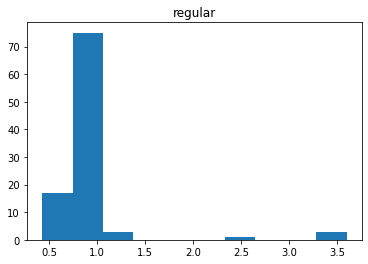

In [ ]:
plt.hist(test_per_re)
plt.title("regular")

(array([82., 13.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

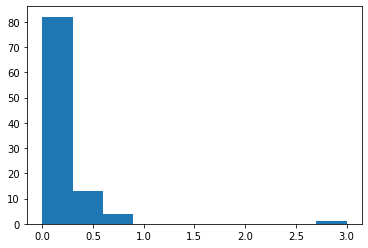

In [ ]:
plt.hist(test_per_ir)
